In [1]:
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import multiprocessing
import os
import numpy as np
import tensorflow as tf
from tensorflow.python import eager as tfe
import matplotlib.pyplot as plt
tf.executing_eagerly()
import datetime

from collections import deque
import random
import gym as gym
from gym.wrappers import Monitor
from gym import logger as gymlogger

In [2]:
class ReplayBuffer(object):
    def __init__(self, max_size=1e6):
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def add(self, data):
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        x, y, u, r, d = [], [], [], [], []

        for i in ind: 
            X, Y, U, R, D = self.storage[i]
            x.append(np.array(X, copy=False))
            y.append(np.array(Y, copy=False))
            u.append(np.array(U, copy=False))
            r.append(np.array(R, copy=False))
            d.append(np.array(D, copy=False))

        return np.array(x), np.array(y), np.array(u), np.array(r).reshape(-1, 1), np.array(d).reshape(-1, 1)

In [3]:
## Modifying

class Actor(tf.keras.Model):
    def __init__(self, action_dim, max_action):
        super().__init__(self)
        self.max_action = max_action
        self.dense1 = tf.keras.layers.Dense(units=400, 
                                            kernel_initializer= tf.keras.initializers.he_uniform(),
                                            activation= tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(units=300, 
                                            kernel_initializer= tf.keras.initializers.he_uniform(),
                                            activation= tf.nn.relu)
        self.dense3 = tf.keras.layers.Dense(units=action_dim, 
                                            kernel_initializer= tf.keras.initializers.he_uniform()
                                           )
        
        
    def call(self, inputs):
        
        result = self.dense1(inputs)
        result = self.dense2(result)
        result = self.dense3(result)
        result = self.max_action * tf.nn.tanh(result)

        
        return result

    
class Critic(tf.keras.Model):
    def __init__(self, action_dim, wd = 1e-2):
        super().__init__(self)
        
        self.layer1 = tf.keras.layers.Dense(400, 
                                            kernel_initializer= tf.keras.initializers.he_uniform(),
                                            kernel_regularizer= tf.keras.regularizers.l2(wd),
                                            bias_regularizer= tf.keras.regularizers.l2(wd),
                                            activation= tf.nn.relu)
        self.layer2 = tf.keras.layers.Dense(300, 
                                            kernel_initializer= tf.keras.initializers.he_uniform(),
                                            kernel_regularizer= tf.keras.regularizers.l2(wd),
                                            bias_regularizer= tf.keras.regularizers.l2(wd),
                                            activation= tf.nn.relu)
        self.layer3 = tf.keras.layers.Dense(1, 
                                            kernel_initializer= tf.keras.initializers.he_uniform(),
                                            kernel_regularizer= tf.keras.regularizers.l2(wd),
                                            bias_regularizer= tf.keras.regularizers.l2(wd)
                                           )
        
    def call(self, inputs):
        
        x, n = inputs
        
        result = self.layer1(x)
        result = tf.concat([result, n], axis = 1)
        result = self.layer2(result)
        result = self.layer3(result)
        return result

In [4]:
import numpy as np
import tensorflow as tf
layers = tf.keras.layers
regularizers = tf.keras.regularizers
losses = tf.keras.losses

class DDPG():
    def __init__(self,  env, continiuous = True):
        self.env = env
        self.continiuous = continiuous
        self.steps_before_train = 20000
        self.memory_capacity = 80000
        self.batch_size = 256
        self.memory = ReplayBuffer()
        self.expl_noise = 0.4 # Std of Gaussian exploration noise
#         self.actor_globalsteps = tf.train.get_or_create_global_step()
#         self.critic_globalsteps = tf.train.get_or_create_global_step()
        self.steps = 0
        self.volume = 5
        self.total_rewards = []
        self.epsilon = 1.2
        

        
        self.max_action = self.env.action_space.high
        if self.env.action_space.shape == ():
            self.action_dim = env.action_space.n
        else:
            self.action_dim = env.action_space.shape[0]
        self.state_dim = env.observation_space.shape[0]
        
        
        self.actor = Actor(self.action_dim, self.max_action)
        self.actor_target = Actor(self.action_dim, self.max_action)
        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        
        #initialize target network
        for param, target_param in zip(self.actor.weights, self.actor_target.weights):
            target_param.assign(param)
        
        self.critic = Critic(self.action_dim)
        self.critic_target = Critic(self.action_dim)
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
        
         #initialize target network
        for param, target_param in zip(self.critic.weights, self.critic_target.weights):
            target_param.assign(param)
            
    def select_action(self, state):
        """
        :Select Continious Action:
        """
        
        state = np.expand_dims(state, axis = 0).astype(np.float32)
        action = self.actor(state).numpy()
#         print(action)
        return action[0]

    def run(self, env = gym.make('CartPole-v0'), render = False):
        self.env = env
        s = self.env.reset()
        step = 0
        while True:
            if render:
                env.render()
            action = self.select_action(s)
            s_1, reward, done, info = self.env.step(action)
            s = s_1
            step += 1

            if done:
                print("Episode finished successfully after {} timesteps".format(step))
                break

        self.env.close()   

    def train(self, episodes):
        
        
        ## Pre-train to store memory
        for epoch in range(episodes):
            epoch_reward = 0
            s = self.env.reset()

            
            while True:
                if self.steps < self.steps_before_train:
                    action = env.action_space.sample()
                else:
                    self.learn()
                    action = self.select_action(s)
                    if (self.expl_noise != 0) & self.continiuous:
                        # Noise:  action = action + normal distribution(mean =0, std = expl_noise)
                        action = (action + self.epsilon*np.random.normal(0, self.expl_noise, size=env.action_space.shape[0])).clip(env.action_space.low, env.action_space.high)

                        
                s_1, reward, done, _ = self.env.step(action)
                
                
                # additional reward
                add_r = np.abs(s_1[0] - (-0.5))*5
                if reward >99:
                    reward *= 20
                    
                reward += add_r

                self.memory.add((s, s_1, action, reward, done))
                                    
                s = s_1
                self.steps += 1
                
                epoch_reward += reward
                
                if done:
                    self.total_rewards.append(np.round(epoch_reward,3))
                    break
                    
            self.epsilon -= (self.epsilon/100)
            self.epsilon = np.maximum(0.005, self.epsilon)
            
            if epoch % self.volume == 0:
                print('Episode trained...', epoch+1,'Reward:',epoch_reward)
                
            if (epoch % (self.volume*4) == 0) & (epoch > 0):
                plt.plot(self.total_rewards)
                plt.show()
           
                
        
#     @tf.contrib.eager.defun
    def learn(self, gamma = 0.99, tau = 0.005):

        s, s_1, a, r, done = self.memory.sample(self.batch_size)

        s = tf.constant(s, dtype = tf.float32)
        a = tf.constant(a, dtype = tf.float32)
        s_1 = tf.constant(s_1, dtype = tf.float32)
        r = tf.constant(r, dtype = tf.float32)
        done = tf.constant(done, dtype = tf.float32)
        
#         s = np.array(s, dtype = np.float32)
#         a = np.array(a, dtype = np.float32)
#         s_1 = np.array(s_1, dtype = np.float32)
#         r = np.array(r, dtype = np.float32)
#         done = np.array(done, dtype = np.float32)


        not_done = 1-done

        with tf.GradientTape() as tape:
            s_1_target = self.actor_target(s)
            target_Q = self.critic_target([s_1, s_1_target])
            target_Q = r + (not_done * gamma * target_Q)
            current_Q = self.critic([s, a])

            # Compute Critic Loss + L2 Loss
            loss = tf.reduce_mean((current_Q - target_Q) ** 2)
            critic_loss = tf.reduce_mean(loss + 0.5 * tf.add_n(self.critic.losses))

        critic_grads = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables),
#                                               global_step= self.critic_globalsteps
                                             )


        with tf.GradientTape() as tape:
            action = self.actor(s)
            actor_loss = - tf.reduce_mean(self.critic([s, action]))
            
        actor_grads = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables),
#                                              global_step= self.actor_globalsteps
                                            )

        
        ## Update target networks every step (smoothing method) (can be periodic)

        for param, target_param in zip(self.critic.weights, self.critic_target.weights):
            target_param.assign( tau * param + (1-tau) * target_param)

        for param, target_param in zip(self.actor.weights, self.actor_target.weights):
            target_param.assign( tau * param + (1-tau) * target_param)

            
            


In [6]:
env = gym.make('MountainCarContinuous-v0')
DDPGAgent = DDPG(env)

Episode trained... 1 Reward: 674.3864350602246


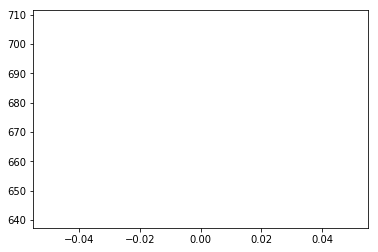

Episode trained... 6 Reward: 529.6586302560548
Episode trained... 11 Reward: 1288.9667508730056
Episode trained... 16 Reward: 498.1126379390389
Episode trained... 21 Reward: 1016.2526850655341


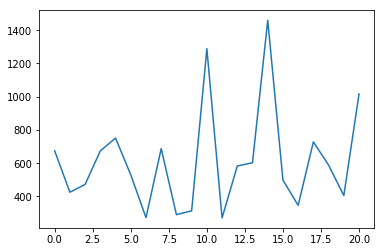

Episode trained... 26 Reward: 963.9341581162108
Episode trained... 31 Reward: 2693.539048194874
Episode trained... 36 Reward: 2629.911500643585
Episode trained... 41 Reward: 2141.5783354712235


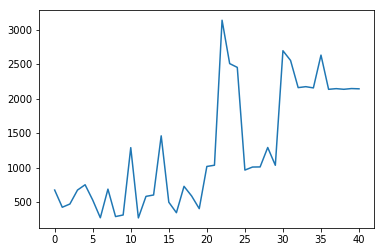

Episode trained... 46 Reward: 2131.803462155709
Episode trained... 51 Reward: 2115.5800315717606
Episode trained... 56 Reward: 2117.251263650195
Episode trained... 61 Reward: 2112.1393970454105


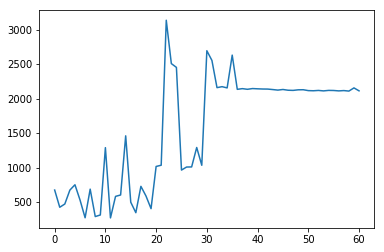

Episode trained... 66 Reward: 2101.757733069227
Episode trained... 71 Reward: 2099.6500528224287
Episode trained... 76 Reward: 2159.0686270231718
Episode trained... 81 Reward: 2129.397980703656


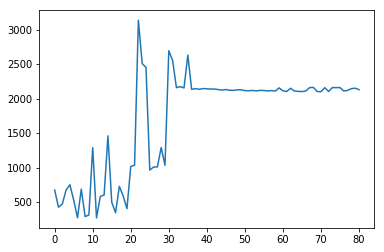

Episode trained... 86 Reward: 2159.2379566288646
Episode trained... 91 Reward: 2136.4399517523684
Episode trained... 96 Reward: 2113.6789957353303


In [7]:
DDPGAgent.train(100)

In [4]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")


def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env


In [11]:
DDPGAgent.run(env)

Episode finished successfully after 999 timesteps


In [9]:

env = wrap_env(gym.make('MountainCarContinuous-v0'))

DDPGAgent.run(env)
show_video()


Episode finished successfully after 106 timesteps


In [6]:
class DDPG():
    def __init__(self,  env, continiuous = True):
        self.env = env
        self.continiuous = continiuous
        self.steps_before_train = 20000
        self.memory_capacity = 80000
        self.batch_size = 256
        self.memory = ReplayBuffer()
        self.expl_noise = 0.4 # Std of Gaussian exploration noise
#         self.actor_globalsteps = tf.train.get_or_create_global_step()
#         self.critic_globalsteps = tf.train.get_or_create_global_step()
        self.steps = 0
        self.volume = 5
        self.total_rewards = []
        self.epsilon = 1
        

        
        self.max_action = self.env.action_space.high
        if self.env.action_space.shape == ():
            self.action_dim = env.action_space.n
        else:
            self.action_dim = env.action_space.shape[0]
        self.state_dim = env.observation_space.shape[0]
        
        
        self.actor = Actor(self.action_dim, self.max_action)
        self.actor_target = Actor(self.action_dim, self.max_action)
        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        
        #initialize target network
        for param, target_param in zip(self.actor.weights, self.actor_target.weights):
            target_param.assign(param)
        
        self.critic = Critic(self.action_dim)
        self.critic_target = Critic(self.action_dim)
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
        
         #initialize target network
        for param, target_param in zip(self.critic.weights, self.critic_target.weights):
            target_param.assign(param)
            
    def select_action(self, state):
        """
        :Select Continious Action:
        """
        
        state = np.expand_dims(state, axis = 0).astype(np.float32)
        action = self.actor(state).numpy()
#         print(action)
        return action[0]

    def run(self, env = gym.make('CartPole-v0'), render = False):
        self.env = env
        s = self.env.reset()
        step = 0
        while True:
            if render:
                env.render()
            action = self.select_action(s)
            s_1, reward, done, info = self.env.step(action)
            s = s_1
            step += 1

            if done:
                print("Episode finished successfully after {} timesteps".format(step))
                break

        self.env.close()   

    def train(self, episodes):
        
        
        ## Pre-train to store memory
        for epoch in range(episodes):
            epoch_reward = 0
            s = self.env.reset()

            
            while True:
                if self.steps < self.steps_before_train:
                    action = env.action_space.sample()
                else:
                    self.learn()
                    action = self.select_action(s)
                    if (self.expl_noise != 0) & self.continiuous:
                        # Noise:  action = action + normal distribution(mean =0, std = expl_noise)
                        action = (action + self.epsilon*np.random.normal(0, self.expl_noise, size=env.action_space.shape[0])).clip(env.action_space.low, env.action_space.high)

                        
                s_1, reward, done, _ = self.env.step(action)
                
                
                # additional reward
#                 add_r = np.abs(s_1[0] - (-0.5))*5
#                 if reward >99:
#                     reward *= 20
                    
#                 reward += add_r

                self.memory.add((s, s_1, action, reward, done))
                                    
                s = s_1
                self.steps += 1
                
                epoch_reward += reward
                
                if done:
                    self.total_rewards.append(np.round(epoch_reward,3))
                    break
                    
            self.epsilon -= (self.epsilon/100)
            self.epsilon = np.maximum(0.005, self.epsilon)
            
            if epoch % self.volume == 0:
                print('Episode trained...', epoch+1,'Reward:',epoch_reward)
                
            if (epoch % (self.volume*4) == 0) & (epoch > 0):
                plt.plot(self.total_rewards)
                plt.show()
           
                
        
#     @tf.contrib.eager.defun
    def learn(self, gamma = 0.99, tau = 0.005):

        s, s_1, a, r, done = self.memory.sample(self.batch_size)

        s = tf.constant(s, dtype = tf.float32)
        a = tf.constant(a, dtype = tf.float32)
        s_1 = tf.constant(s_1, dtype = tf.float32)
        r = tf.constant(r, dtype = tf.float32)
        done = tf.constant(done, dtype = tf.float32)
        
#         s = np.array(s, dtype = np.float32)
#         a = np.array(a, dtype = np.float32)
#         s_1 = np.array(s_1, dtype = np.float32)
#         r = np.array(r, dtype = np.float32)
#         done = np.array(done, dtype = np.float32)


        not_done = 1-done

        with tf.GradientTape() as tape:
            s_1_target = self.actor_target(s)
            target_Q = self.critic_target([s_1, s_1_target])
            target_Q = r + (not_done * gamma * target_Q)
            current_Q = self.critic([s, a])

            # Compute Critic Loss + L2 Loss
            loss = tf.reduce_mean((current_Q - target_Q) ** 2)
            critic_loss = tf.reduce_mean(loss + 0.5 * tf.add_n(self.critic.losses))

        critic_grads = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables),
#                                               global_step= self.critic_globalsteps
                                             )


        with tf.GradientTape() as tape:
            action = self.actor(s)
            actor_loss = - tf.reduce_mean(self.critic([s, action]))
            
        actor_grads = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables),
#                                              global_step= self.actor_globalsteps
                                            )

        
        ## Update target networks every step (smoothing method) (can be periodic)

        for param, target_param in zip(self.critic.weights, self.critic_target.weights):
            target_param.assign( tau * param + (1-tau) * target_param)

        for param, target_param in zip(self.actor.weights, self.actor_target.weights):
            target_param.assign( tau * param + (1-tau) * target_param)

            
            


Episode trained... 1 Reward: -33.483509103312684
Episode trained... 6 Reward: -33.99800253122097
Episode trained... 11 Reward: -32.81709611159744
Episode trained... 16 Reward: -32.92642916558873
Episode trained... 21 Reward: -70.0086025952832


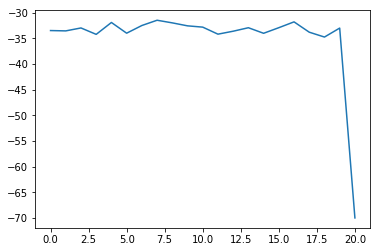

Episode trained... 26 Reward: -10.06404480454973
Episode trained... 31 Reward: -8.83386754353091
Episode trained... 36 Reward: -11.160335074186529
Episode trained... 41 Reward: -11.848250039413982


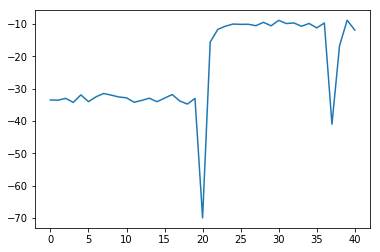

Episode trained... 46 Reward: -7.69786055927696
0:12:15.172784


In [7]:
t1 = datetime.datetime.now()

env = gym.make('MountainCarContinuous-v0')
DDPGAgent = DDPG(env)

DDPGAgent.train(50)


t2 = datetime.datetime.now()

TDiff_Fast = t2- t1
print(TDiff_Fast)

Episode trained... 1 Reward: -10.444151986035926
Episode trained... 6 Reward: -8.295945889994767
Episode trained... 11 Reward: -8.843197290912753
Episode trained... 16 Reward: -42.40813433704214
Episode trained... 21 Reward: -14.088584225029535


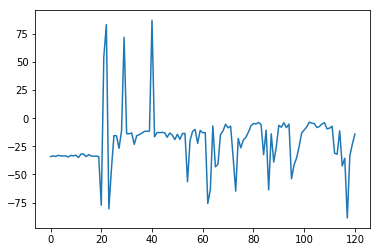

Episode trained... 26 Reward: -26.56877719295012
Episode trained... 31 Reward: -4.665808585956175
Episode trained... 36 Reward: -11.470287727843676
Episode trained... 41 Reward: -8.627971550454737


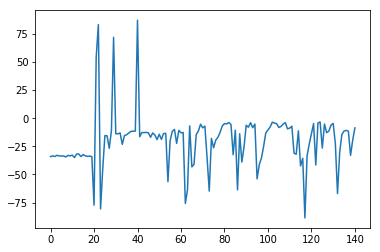

Episode trained... 46 Reward: -5.590465062386264
Episode trained... 51 Reward: -15.137952666358702
Episode trained... 56 Reward: -93.51778559647737
Episode trained... 61 Reward: -34.42005732940121


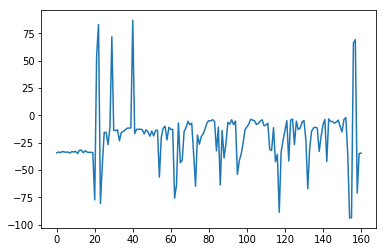

Episode trained... 66 Reward: -16.23548046299328
Episode trained... 71 Reward: -10.454401957040265
Episode trained... 76 Reward: -12.626073663987482
Episode trained... 81 Reward: -9.062086718621211


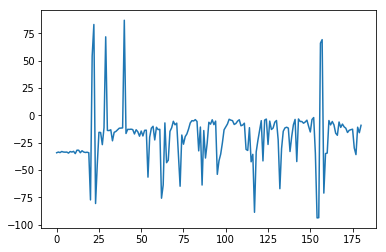

Episode trained... 86 Reward: -9.185001246201185
Episode trained... 91 Reward: -12.15344950581179
Episode trained... 96 Reward: -3.3465169894480047


In [16]:
DDPGAgent.train(100)

In [13]:

env = wrap_env(gym.make('MountainCarContinuous-v0'))

DDPGAgent.run(env)
show_video()

Episode finished successfully after 999 timesteps


In [23]:
class DDPG_Fast():
    def __init__(self,  env, continiuous = True):
        self.env = env
        self.continiuous = continiuous
        self.steps_before_train = 20000
        self.memory_capacity = 100000
        self.batch_size = 256
        self.memory = ReplayBuffer()
        self.expl_noise = 0.3 # Std of Gaussian exploration noise
#         self.actor_globalsteps = tf.train.get_or_create_global_step()
#         self.critic_globalsteps = tf.train.get_or_create_global_step()
        self.steps = 0
        self.volume = 5
        self.total_rewards = []
        self.epsilon = 1.3
        self.decrease_steps = 150
        self.decrease_min = 0.2
        

        
        self.max_action = self.env.action_space.high
        if self.env.action_space.shape == ():
            self.action_dim = env.action_space.n
        else:
            self.action_dim = env.action_space.shape[0]
        self.state_dim = env.observation_space.shape[0]
        
        
        self.actor = Actor(self.action_dim, self.max_action)
        self.actor_target = Actor(self.action_dim, self.max_action)
        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        
        #initialize target network
        for param, target_param in zip(self.actor.weights, self.actor_target.weights):
            target_param.assign(param)
        
        self.critic = Critic(self.action_dim)
        self.critic_target = Critic(self.action_dim)
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
        
         #initialize target network
        for param, target_param in zip(self.critic.weights, self.critic_target.weights):
            target_param.assign(param)
            
    def select_action(self, state):
        """
        :Select Continious Action:
        """
        
        state = np.expand_dims(state, axis = 0).astype(np.float32)
        action = self._select_action_body(state).numpy()
#         print(action)
        return action[0]

#===================== Eager to Grpth for Choosing Action =====================#

    @tf.function
    def _select_action_body(self, state):
        action = self.actor(state)
        return action

#===================== Eager to Grpth for Choosing Action =====================#

    def run(self, env = gym.make('CartPole-v0'), render = False):
        self.env = env
        s = self.env.reset()
        step = 0
        while True:
            if render:
                env.render()
            action = self.select_action(s)
            s_1, reward, done, info = self.env.step(action)
            s = s_1
            step += 1

            if done:
                print("Episode finished successfully after {} timesteps".format(step))
                break

        self.env.close()   

    def train(self, episodes):
        
        
        ## Pre-train to store memory
        for epoch in range(episodes):
            epoch_reward = 0
            s = self.env.reset()

            
            while True:
                if self.steps < self.steps_before_train:
                    action = env.action_space.sample()
                else:
                    self.learn()
                    action = self.select_action(s)
                    if (self.expl_noise != 0) & self.continiuous:
                        # Noise:  action = action + (decreasing epsilon) * Gaussian distribution(mean =0, std = expl_noise)
                        action = (action + self.epsilon*np.random.normal(0, self.expl_noise, size=env.action_space.shape[0])).clip(env.action_space.low, env.action_space.high)

                        
                s_1, reward, done, _ = self.env.step(action)
                
                
                # additional reward
#                 add_r = np.abs(s_1[0] - (-0.5))*5
#                 if reward >99:
#                     reward *= 20
                    
#                 reward += add_r

                self.memory.add((s, s_1, action, reward, done))
                                    
                s = s_1
                self.steps += 1
                
                epoch_reward += reward
                
                if done:
                    self.total_rewards.append(np.round(epoch_reward,3))
                    break
                    
            self.epsilon -= (self.epsilon/self.decrease_steps)
            self.epsilon = np.maximum(self.decrease_min, self.epsilon)
            
            if epoch % self.volume == 0:
                print('Episode trained...', epoch+1,'Reward:',epoch_reward)
                
            if (epoch % (self.volume*4) == 0) & (epoch > 0):
                plt.plot(self.total_rewards)
                plt.show()
           
                
        
#     @tf.contrib.eager.defun
    def learn(self, gamma = 0.99, tau = 0.005):

        s, s_1, a, r, done = self.memory.sample(self.batch_size)

        s = tf.constant(s, dtype = tf.float32)
        a = tf.constant(a, dtype = tf.float32)
        s_1 = tf.constant(s_1, dtype = tf.float32)
        r = tf.constant(r, dtype = tf.float32)
        done = tf.constant(done, dtype = tf.float32)
        not_done = 1-done
        
        self._learn_body(s, a, s_1, r, not_done, gamma, tau)


#===================== Eager to Grpth for Main Train =====================#
    @tf.function
    def _learn_body(self, s, a, s_1, r, not_done, gamma, tau):
        
        with tf.GradientTape() as tape:
            s_1_target = self.actor_target(s)
            target_Q = self.critic_target([s_1, s_1_target])
            target_Q = r + (not_done * gamma * target_Q)
            current_Q = self.critic([s, a])

            # Compute Critic Loss + L2 Loss
            loss = tf.reduce_mean((current_Q - target_Q) ** 2)
            critic_loss = tf.reduce_mean(loss + 0.5 * tf.add_n(self.critic.losses))

        critic_grads = tape.gradient(critic_loss, self.critic.trainable_variables)
        
        self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables))


        with tf.GradientTape() as tape:
            action = self.actor(s)
            actor_loss = - tf.reduce_mean(self.critic([s, action]))
            
        actor_grads = tape.gradient(actor_loss, self.actor.trainable_variables)
        
        self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))

        
        ## Update target networks every step (smoothing method) (can be periodic)

        for param, target_param in zip(self.critic.weights, self.critic_target.weights):
            target_param.assign( tau * param + (1-tau) * target_param)

        for param, target_param in zip(self.actor.weights, self.actor_target.weights):
            target_param.assign( tau * param + (1-tau) * target_param)
#===================== Eager to Grpth for Main Train =====================#
            
            


Episode trained... 1 Reward: -32.87121307894226
Episode trained... 6 Reward: -34.906299567113265
Episode trained... 11 Reward: -32.77590731473978
Episode trained... 16 Reward: -33.89604117743342
Episode trained... 21 Reward: 71.68332346824192


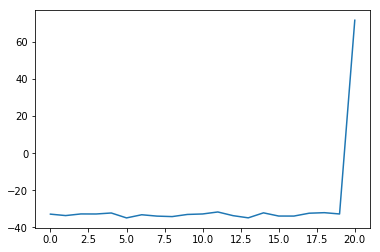

Episode trained... 26 Reward: -12.162453329768153
Episode trained... 31 Reward: -12.891707252204071
Episode trained... 36 Reward: -11.339765861187528
Episode trained... 41 Reward: -12.103592330726562


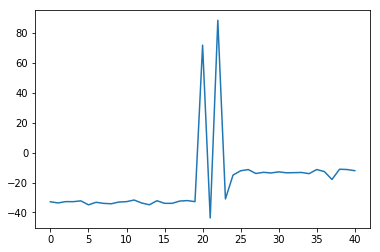

Episode trained... 46 Reward: -11.287593990173065
Episode trained... 51 Reward: -13.850109034898622
Episode trained... 56 Reward: -18.833307251491618
Episode trained... 61 Reward: -17.505604715868028


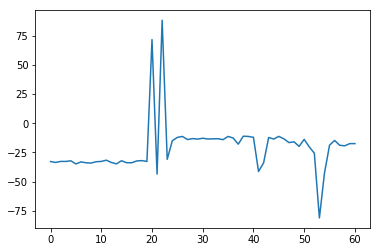

Episode trained... 66 Reward: -16.460463783399643


In [ ]:
t1 = datetime.datetime.now()


env = gym.make('MountainCarContinuous-v0')
DDPGAgent = DDPG_Fast(env)

DDPGAgent.train(150)

t2 = datetime.datetime.now()

TDiff_Faster = t2- t1
print(TDiff_Faster)